In [73]:
class FullyConnectedNN:
    def __init__(self, layers):
        self.layers = layers
        self.weights = []
        self.biases = []
        self.best_loss = float('inf')  # Initialize with a high value
        
        # Initialize weights and biases using He initialization
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i]))
            self.biases.append(np.zeros((1, layers[i + 1])))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return np.where(z > 0, 1, 0)

    def softmax(self, z):
        # Check for NaN or Inf in z before applying softmax
        if np.any(np.isnan(z)) or np.any(np.isinf(z)):
            print("Warning: NaN or Inf detected in z before softmax.")
        z_stable = z - np.max(z, axis=1, keepdims=True)  # Stability improvement
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def feedforward(self, X, training=True):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            if i == len(self.weights) - 1:  # Output layer
                a = self.softmax(z)
            else:  # Hidden layers
                a = self.relu(z)
            activations.append(a)
        return activations

    def backpropagation(self, X, y, learning_rate):
        activations = self.feedforward(X, training=True)
        deltas = [activations[-1] - y]

        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T)
            delta *= self.relu_derivative(activations[i])
            deltas.append(delta)

        deltas.reverse()

        for i in range(len(self.weights)):
            # Update weights and biases with gradient clipping
            grad_w = np.dot(activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)
            grad_w = np.clip(grad_w, -2.0, 2.0)  # Clip gradients to prevent explosion
            grad_b = np.clip(grad_b, -2.0, 2.0)
            self.weights[i] -= learning_rate * grad_w
            self.biases[i] -= learning_rate * grad_b

    def train(self, X, y, X_val, y_val, epochs, learning_rate):
        for epoch in range(epochs):
            self.backpropagation(X, y, learning_rate)
            train_loss = self.calculate_loss(X, y)
            val_loss = self.calculate_loss(X_val, y_val)
            accuracy = self.calculate_accuracy(X_val, y_val)

            # Save the best weights based on validation loss
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
                self.save_best_weights('best_weights.npy', best_weights, best_biases)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    def predict(self, X):
        return self.feedforward(X, training=False)[-1]

    def calculate_loss(self, X, y):
        predictions = self.predict(X)
        # Add epsilon to avoid log(0)
        return -np.mean(np.sum(y * np.log(predictions + 1e-8), axis=1))

    def calculate_accuracy(self, X, y):
        predictions = self.predict(X)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predicted_labels == true_labels)

    def save_best_weights(self, filepath, best_weights, best_biases):
        np.save(filepath, {'weights': best_weights, 'biases': best_biases})
        print("Best weights saved to disk.")

    def load_weights(self, filepath):
        data = np.load(filepath, allow_pickle=True).item()
        self.weights = data['weights']
        self.biases = data['biases']
        print("Best weights loaded from disk.")

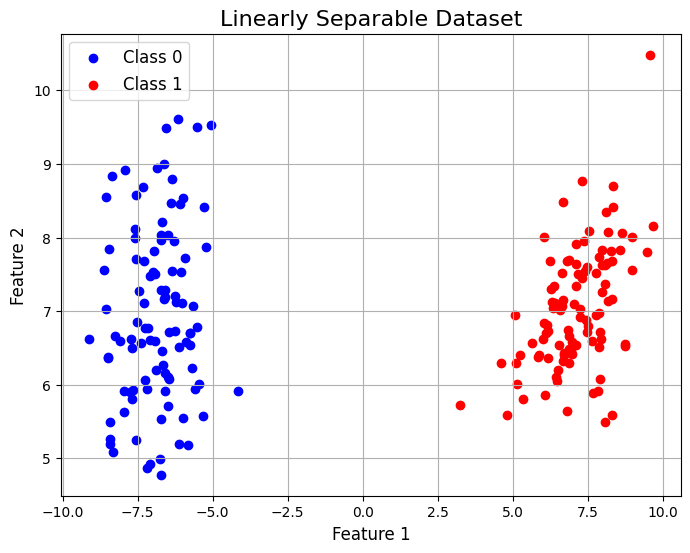

In [74]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification

# Generate a linearly separable dataset
X, y = make_classification(
    n_samples=200,       # Number of samples
    n_features=2,        # Number of features
    n_informative=2,     # Number of informative features (affect the output)
    n_redundant=0,       # Number of redundant features
    n_clusters_per_class=1,  # Each class forms one cluster
    class_sep=7.0,       # Larger value makes the dataset more separable
    random_state=42      # Ensures reproducibility
)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.title("Linearly Separable Dataset", fontsize=16)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42 
)


# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [76]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (120, 2)
y_train shape: (120, 2)


In [77]:
#NO HIDDEN LAYERS
input_size = X_train.shape[1]  # Number of features
output_size = y_train.shape[1]  # Number of classes

# Create the neural network
nn = FullyConnectedNN(layers=[input_size,output_size])

nn.train(X_train,y_train,X_val,y_val,epochs=50,learning_rate=0.005)

Epoch 0, Train Loss: 0.0129, Val Loss: 0.0171, Accuracy: 1.0000
Best weights saved to disk.
Epoch 0, Train Loss: 0.0129, Val Loss: 0.0171, Accuracy: 1.0000
Epoch 1, Train Loss: 0.0099, Val Loss: 0.0134, Accuracy: 1.0000
Best weights saved to disk.
Epoch 2, Train Loss: 0.0076, Val Loss: 0.0106, Accuracy: 1.0000
Best weights saved to disk.
Epoch 3, Train Loss: 0.0059, Val Loss: 0.0083, Accuracy: 1.0000
Best weights saved to disk.
Epoch 4, Train Loss: 0.0046, Val Loss: 0.0066, Accuracy: 1.0000
Best weights saved to disk.
Epoch 5, Train Loss: 0.0035, Val Loss: 0.0052, Accuracy: 1.0000
Best weights saved to disk.
Epoch 6, Train Loss: 0.0027, Val Loss: 0.0041, Accuracy: 1.0000
Best weights saved to disk.
Epoch 7, Train Loss: 0.0021, Val Loss: 0.0033, Accuracy: 1.0000
Best weights saved to disk.
Epoch 8, Train Loss: 0.0017, Val Loss: 0.0027, Accuracy: 1.0000
Best weights saved to disk.
Epoch 9, Train Loss: 0.0015, Val Loss: 0.0023, Accuracy: 1.0000
Best weights saved to disk.
Epoch 10, Train 

In [78]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(X_test, y_test)
loss = nn.calculate_loss(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 100.00%
Test Loss: 0.002526002236599029


In [79]:
# 1 HIDDEN LAYER with 10 neuron

input_size = X_train.shape[1]  # Number of features
output_size = y_train.shape[1]  # Number of classes

# Create the neural network
nn = FullyConnectedNN(layers=[input_size,10,output_size])

nn.train(X_train,y_train,X_val,y_val,epochs=50,learning_rate=0.005)

Epoch 0, Train Loss: 1.4966, Val Loss: 1.1796, Accuracy: 0.5750
Best weights saved to disk.
Epoch 0, Train Loss: 1.4966, Val Loss: 1.1796, Accuracy: 0.5750
Epoch 1, Train Loss: 1.1433, Val Loss: 0.9057, Accuracy: 0.5750
Best weights saved to disk.
Epoch 2, Train Loss: 0.8206, Val Loss: 0.6548, Accuracy: 0.6000
Best weights saved to disk.
Epoch 3, Train Loss: 0.5449, Val Loss: 0.4400, Accuracy: 0.6250
Best weights saved to disk.
Epoch 4, Train Loss: 0.3323, Val Loss: 0.2740, Accuracy: 0.8250
Best weights saved to disk.
Epoch 5, Train Loss: 0.1877, Val Loss: 0.1593, Accuracy: 0.9500
Best weights saved to disk.
Epoch 6, Train Loss: 0.0998, Val Loss: 0.0878, Accuracy: 1.0000
Best weights saved to disk.
Epoch 7, Train Loss: 0.0509, Val Loss: 0.0466, Accuracy: 1.0000
Best weights saved to disk.
Epoch 8, Train Loss: 0.0254, Val Loss: 0.0241, Accuracy: 1.0000
Best weights saved to disk.
Epoch 9, Train Loss: 0.0125, Val Loss: 0.0124, Accuracy: 1.0000
Best weights saved to disk.
Epoch 10, Train 

In [80]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(X_test, y_test)
loss = nn.calculate_loss(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 100.00%
Test Loss: 0.0004455374586369813


In [81]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the moons dataset
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

print(X[:5])
print(y[:5])

[[-1.04942573  0.08444263]
 [ 0.92281755  0.45748851]
 [ 0.65678659  0.69959669]
 [ 1.1889402  -0.38652807]
 [ 0.28926455 -0.13774489]]
[0 0 0 1 1]


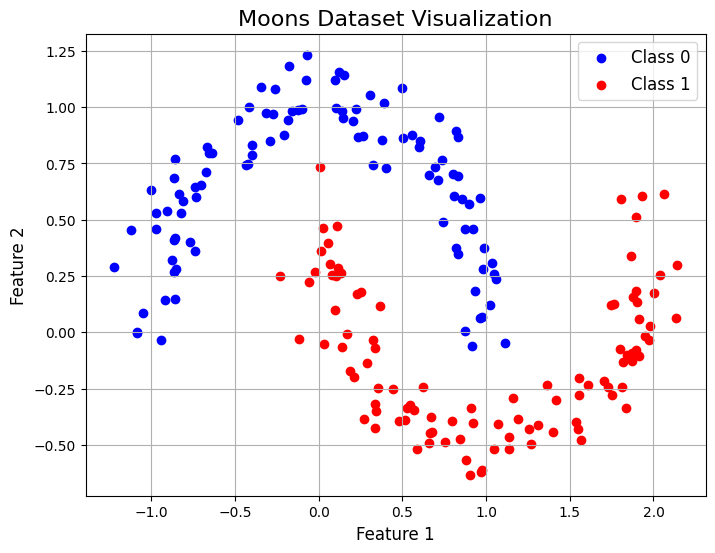

In [82]:
# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0') #class 0 first feature then second feature
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.title("Moons Dataset Visualization", fontsize=16)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [83]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42 
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42 
)


# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_val = encoder.transform(y_val.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [84]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (120, 2)
y_train shape: (120, 2)


In [85]:
#NO HIDDEN LAYERS
input_size = X_train.shape[1]  # Number of features
output_size = y_train.shape[1]  # Number of classes

# Create the neural network
nn = FullyConnectedNN(layers=[input_size,output_size])

nn.train(X_train,y_train,X_val,y_val,epochs=50,learning_rate=0.005)

Epoch 0, Train Loss: 0.8054, Val Loss: 0.7022, Accuracy: 0.5750
Best weights saved to disk.
Epoch 0, Train Loss: 0.8054, Val Loss: 0.7022, Accuracy: 0.5750
Epoch 1, Train Loss: 0.7911, Val Loss: 0.6900, Accuracy: 0.5750
Best weights saved to disk.
Epoch 2, Train Loss: 0.7770, Val Loss: 0.6780, Accuracy: 0.5750
Best weights saved to disk.
Epoch 3, Train Loss: 0.7632, Val Loss: 0.6663, Accuracy: 0.5750
Best weights saved to disk.
Epoch 4, Train Loss: 0.7496, Val Loss: 0.6548, Accuracy: 0.5750
Best weights saved to disk.
Epoch 5, Train Loss: 0.7363, Val Loss: 0.6436, Accuracy: 0.5750
Best weights saved to disk.
Epoch 6, Train Loss: 0.7232, Val Loss: 0.6326, Accuracy: 0.6000
Best weights saved to disk.
Epoch 7, Train Loss: 0.7103, Val Loss: 0.6219, Accuracy: 0.6250
Best weights saved to disk.
Epoch 8, Train Loss: 0.6977, Val Loss: 0.6115, Accuracy: 0.6500
Best weights saved to disk.
Epoch 9, Train Loss: 0.6853, Val Loss: 0.6013, Accuracy: 0.6500
Best weights saved to disk.
Epoch 10, Train 

In [86]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(X_test, y_test)
loss = nn.calculate_loss(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 82.50%
Test Loss: 0.43253709779220095


In [87]:
#1 HIDDEN LAYER with 10 neuron
input_size = X_train.shape[1]  # Number of features
output_size = y_train.shape[1]  # Number of classes

# Create the neural network
nn = FullyConnectedNN(layers=[input_size,10,output_size])

nn.train(X_train,y_train,X_val,y_val,epochs=50,learning_rate=0.005)

Epoch 0, Train Loss: 1.1662, Val Loss: 1.3047, Accuracy: 0.1250
Best weights saved to disk.
Epoch 0, Train Loss: 1.1662, Val Loss: 1.3047, Accuracy: 0.1250
Epoch 1, Train Loss: 1.1108, Val Loss: 1.2386, Accuracy: 0.1500
Best weights saved to disk.
Epoch 2, Train Loss: 1.0580, Val Loss: 1.1751, Accuracy: 0.1500
Best weights saved to disk.
Epoch 3, Train Loss: 1.0078, Val Loss: 1.1151, Accuracy: 0.1500
Best weights saved to disk.
Epoch 4, Train Loss: 0.9603, Val Loss: 1.0586, Accuracy: 0.1500
Best weights saved to disk.
Epoch 5, Train Loss: 0.9155, Val Loss: 1.0045, Accuracy: 0.1250
Best weights saved to disk.
Epoch 6, Train Loss: 0.8731, Val Loss: 0.9528, Accuracy: 0.1250
Best weights saved to disk.
Epoch 7, Train Loss: 0.8333, Val Loss: 0.9040, Accuracy: 0.1000
Best weights saved to disk.
Epoch 8, Train Loss: 0.7957, Val Loss: 0.8580, Accuracy: 0.1250
Best weights saved to disk.
Epoch 9, Train Loss: 0.7604, Val Loss: 0.8146, Accuracy: 0.1500
Best weights saved to disk.
Epoch 10, Train 

In [88]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(X_test, y_test)
loss = nn.calculate_loss(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 77.50%
Test Loss: 0.3886432836615389


In [89]:
#2 Hidden Layers
input_size = X_train.shape[1]  # Number of features
output_size = y_train.shape[1]  # Number of classes

# Create the neural network
nn = FullyConnectedNN(layers=[input_size,10,10,output_size])

nn.train(X_train,y_train,X_val,y_val,epochs=50,learning_rate=0.005)

Epoch 0, Train Loss: 0.5028, Val Loss: 0.5005, Accuracy: 0.7500
Best weights saved to disk.
Epoch 0, Train Loss: 0.5028, Val Loss: 0.5005, Accuracy: 0.7500
Epoch 1, Train Loss: 0.4762, Val Loss: 0.4754, Accuracy: 0.7750
Best weights saved to disk.
Epoch 2, Train Loss: 0.4518, Val Loss: 0.4519, Accuracy: 0.7750
Best weights saved to disk.
Epoch 3, Train Loss: 0.4302, Val Loss: 0.4317, Accuracy: 0.7750
Best weights saved to disk.
Epoch 4, Train Loss: 0.4114, Val Loss: 0.4131, Accuracy: 0.7750
Best weights saved to disk.
Epoch 5, Train Loss: 0.3942, Val Loss: 0.3931, Accuracy: 0.7750
Best weights saved to disk.
Epoch 6, Train Loss: 0.3779, Val Loss: 0.3769, Accuracy: 0.7750
Best weights saved to disk.
Epoch 7, Train Loss: 0.3638, Val Loss: 0.3596, Accuracy: 0.8000
Best weights saved to disk.
Epoch 8, Train Loss: 0.3508, Val Loss: 0.3478, Accuracy: 0.8000
Best weights saved to disk.
Epoch 9, Train Loss: 0.3390, Val Loss: 0.3333, Accuracy: 0.8000
Best weights saved to disk.
Epoch 10, Train 

In [90]:
nn.load_weights('best_weights.npy')
accuracy = nn.calculate_accuracy(X_test, y_test)
loss = nn.calculate_loss(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss}")

Best weights loaded from disk.
Test Accuracy: 90.00%
Test Loss: 0.2720345411998121
